## Evaluation of the best two Models

1. 3-Conv-Layer mit 256 Sampling-Size
2. 2-Conv-Layer mit 128 Sampling-Size

In [9]:
# Allows imports from modules in the project directory
import os
import sys
from pathlib import Path

CURRENT_DIRECTORY = Path(os.path.abspath('')).resolve()
MODULE_DIRECTORY = CURRENT_DIRECTORY.parent
PROJECT_DIRECTORY = MODULE_DIRECTORY.parents[1]
sys.path.extend([str(MODULE_DIRECTORY)])

print(f'Python {sys.version} on {sys.platform}')

Python 3.9.19 (main, Jul  7 2024, 08:52:44) 
[Clang 15.0.0 (clang-1500.3.9.4)] on darwin


In [17]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy

import utilities

In [11]:
class DataGenerator(utilities.BaseDataGenerator):
    def transform(self, X: list) -> np.ndarray:
        return X

In [12]:
# Load and split dataset
data, labels, fids, velocities, angles = utilities.load_dataset(MODULE_DIRECTORY / 'data/data_adp.pkl')
train_idx, test_idx, train_data, test_data = utilities.split_dataset(fids, labels, data, seed=42)

utilities.compress_data(train_data, 128)
utilities.compress_data(test_data, 128)

test_labels = labels[test_idx]
train_labels = labels[train_idx]

# Empty
del data

In [13]:
# Labels need to be one-hot encoded for the metrics (and loss function) to work
test_labels = tf.keras.utils.to_categorical(labels[test_idx], 4)
train_labels = tf.keras.utils.to_categorical(labels[train_idx], 4)

In [14]:
# Merge inputs and targets
inputs = np.concatenate((train_data, test_data), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

In [15]:
# Initialize data generators
generator = DataGenerator(inputs, targets, batch_size=1, shuffle=False)

In [18]:
# Data generator allows to transform each batch in training and evaluate the test set after each epoche
COMPRESSION_SIZE = [128, 256]
for comp_size in COMPRESSION_SIZE:

    train_data_temp = copy.deepcopy(train_data)
    test_data_temp = copy.deepcopy(test_data)

    # Pad each batch to the comp_size
    utilities.compress_data(train_data_temp, comp_size)
    utilities.compress_data(test_data_temp, comp_size)

    if comp_size == 128:
        test_generator128 = DataGenerator(test_data_temp, test_labels, batch_size=1, shuffle=False)

    elif comp_size == 256:
        test_generator256 = DataGenerator(test_data_temp, test_labels, batch_size=1, shuffle=False)

In [21]:
# Load the LSTM models
best_model128 = tf.keras.models.load_model(MODULE_DIRECTORY / 'LSTM/models/bestconvlstm128')
best_model256 = tf.keras.models.load_model(MODULE_DIRECTORY / 'LSTM/models/bestconvlstm256')

In [35]:
# Evaluate the model on the test set
loss, test_acc, weighted_loss = best_model128.evaluate(test_generator128)
print('Test accuracy:', test_acc)

6747/6747 [==============================] - 11s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9890 - weighted_loss: 0.0756
Test accuracy: 0.9890321493148804


In [36]:
# Evaluate the model on the test set
loss, test_acc, weighted_loss = best_model256.evaluate(test_generator256)
print('Test accuracy:', test_acc)

6747/6747 [==============================] - 19s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9687 - weighted_loss: 0.1304
Test accuracy: 0.9687268137931824


In [37]:
# Kompiliere das Modell, um gewünschte Metriken zu nutzen
best_model128.compile(metrics=['accuracy', utilities.weighted_loss])
best_model256.compile(metrics=['accuracy', utilities.weighted_loss])

In [38]:
# Predict the labels on the test dataset (this may take a while)
onehot_predictions_128 = best_model128.predict(test_generator128)
predictions_128 = tf.argmax(onehot_predictions_128, axis=1)

6747/6747 [==============================] - 11s 2ms/step


In [39]:
# Predict the labels on the test dataset (this may take a while)
onehot_predictions_256 = best_model256.predict(test_generator256)
predictions_256 = tf.argmax(onehot_predictions_256, axis=1)

6747/6747 [==============================] - 18s 3ms/step


In [40]:
# Calculate the confusion matrix
confusion_matrix_128 = tf.math.confusion_matrix(
    labels=labels[test_idx],
    predictions=predictions_128,
    num_classes=4,
).numpy()

print('Confusion Matrix 128:', confusion_matrix_128, sep='\n')

Confusion Matrix 128:
[[ 831    3    5    0]
 [   0 1546    1   31]
 [   1    2 2533   11]
 [   0   12    8 1763]]


In [41]:
# Calculate the confusion matrix
confusion_matrix_256 = tf.math.confusion_matrix(
    labels=labels[test_idx],
    predictions=predictions_256,
    num_classes=4,
).numpy()

print('Confusion Matrix 256:', confusion_matrix_256, sep='\n')

Confusion Matrix 256:
[[ 829    4    6    0]
 [   1 1564    2   11]
 [  41   16 2429   61]
 [   0   46   23 1714]]


Text(0.5, 0.98, 'Compare Confusion Matrices')

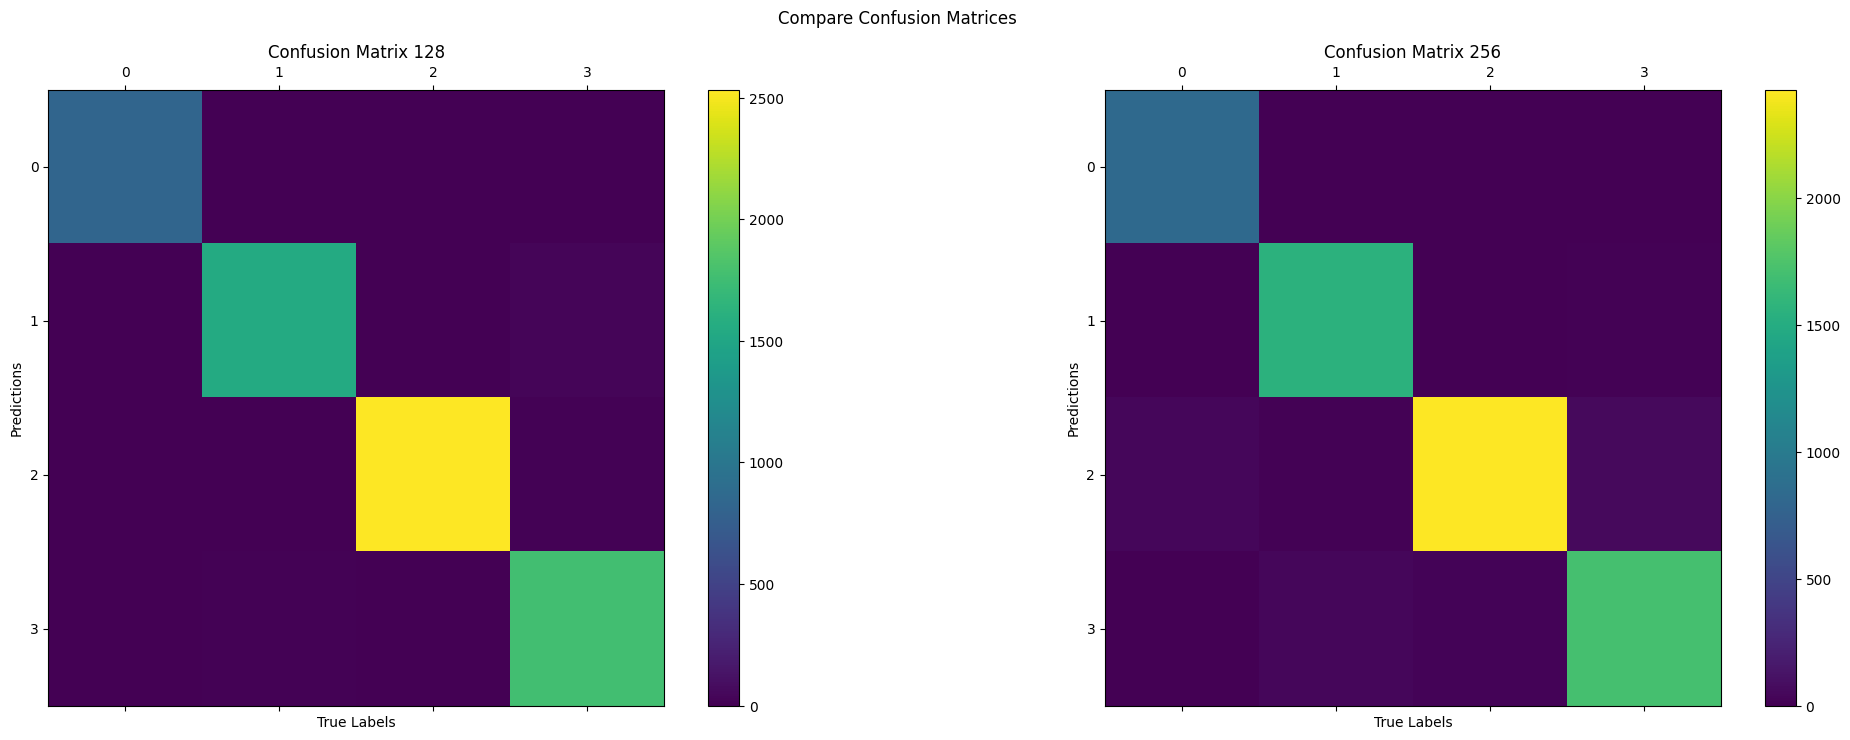

In [42]:
# Show the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))

im1 = ax1.matshow(confusion_matrix_128)
ax1.set(title='Confusion Matrix 128')
ax1.set(ylabel='Predictions')
ax1.set(xlabel='True Labels')
fig.colorbar(im1, ax=ax1)

im2 = ax2.matshow(confusion_matrix_256)
ax2.set(title='Confusion Matrix 256')
ax2.set(ylabel='Predictions')
ax2.set(xlabel='True Labels')
fig.colorbar(im2, ax=ax2)

fig.suptitle("Compare Confusion Matrices")

In [43]:
# Evaluate the MCC on the test set
mcc128 = utilities.matthews_correlation(confusion_matrix_128)
mcc256 = utilities.matthews_correlation(confusion_matrix_256)
print('MCC 128:', mcc128)
print('MCC 256:', mcc256)

MCC 128: 0.9847206017153397
MCC 256: 0.956725690421041


In [47]:
# Convert to tensors
pred128 = tf.constant(onehot_predictions_128)
pred256 = tf.constant(onehot_predictions_256)
true = tf.constant(test_labels)

# Evaluate the loss on the test set
loss128 = utilities.weighted_loss(true, pred128).numpy()
loss256 = utilities.weighted_loss(true, pred256).numpy()
print('Loss 128:', loss128)
print('Loss 256:', loss256)

Loss 128: 0.07559045
Loss 256: 0.13043104
